# BestHack2022 DataScience

## Формулировка задания

По статистике каждый активный абонент в среднем получает более 5-ти нежелательных звонков в неделю. При этом
для разных людей понятия «желаемого» и «нежелательного» трафика могут не совпадать. Один и тот же номер
может использоваться как для назойливого рекламного обзвона, так и для обслуживания клиентов; а на каждого
нового мошенника реагировать нужно как можно быстрее.

В архиве [`transactions.zip`](https://drive.google.com/drive/folders/1Bn3bvV5u15a7enelJwmqyRrWu9Dfm-eZ)
содержатся синтетические данные транзакций голосового трафика за 2 месяца, максимально приближенные к
реальным. В файле `beeline_antispam_hakaton_id_samples.csv` содержатся __id__ абонентов, таргет по которым
известен (train) и по которым нужно предсказать (test).

Сможете ли вы определить, к какому типу относится конкретный номер?
Сможете ли вы построить стабильную и легкую модель?


## Часть I - ML

Требуется построить модель, которая классифицировала бы номера на 5 категорий:
- 0 - не спам
- 1 - небольшие полезные ИП / малые бизнесы
- 2 - организации
- 3 - мобильная карусель
- 4 - чёрные спамеры и мошенники

Метрика - [`fbeta_score(average='macro', beta=0.5)`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html).

На выходе мы ожидаем файл `beeline_antispam_hakaton_id_samples.csv`, в котором для тестовых данных (test)
проставлена одна из 5 категорий.


## Часть II - R&D

Помимо точности предсказания, мы также будем оценивать <u>применимость решения в боевых условиях</u> и
<u>качество инсайтов</u>, полученных из данных.

Идеальное решение должно быть не только точным, но также __стабильным__ и __«лёгким»__.

Лёгким, так как реальные данные в тысячи раз тяжелее, а модель должна работать в режиме, приближенном к
real-time, чтобы с минимальной задержкой реагировать даже на самых продвинутых мошенников, которые быстро
меняют номера и подстраивают своё поведение для обхода антифрод-систем.

Под «лёгкостью» мы понимаем не столько сложность самого алгоритма (одна бустинг модель вполне ОК, десять
«застеканных» моделей - нет), сколько глубину используемых данных (необязательно использовать целый месяц,
можно попробовать ограничиться одной неделей или несколькими днями, если это не сильно влияет на точность).
    
Под стабильностью мы понимаем постоянство качества модели в динамике как в целом по категориям, так и по
каждому конкретному номеру (в идеальном мире один и тот же номер, если он не меняет фактического владельца,
должен иметь одинаковый скор и вчера, и сегодня и завтра). Метрику стабильности, в особенности для случая
с конкретными номерами, мы предлагаем вам придумать самим.

В частности, нам бы хотелось, чтобы вы ответили на следующие вопросы (но, возможно, вы захотите
поисследовать в данных что-то ещё):
1. Какие паттерны поведения номеров помогают отделить категории 1-4 друг от друга?
2. Насколько отличаются предсказания модели, построенные на разных периодах времени?
3. Не «ломается» ли модель в выходные и праздники?
4. Какое минимальное количество дней исторических транзакций требуется для, чтобы построить стабильную
и достаточно точную модель?
5. Какую метрику стабильности скора по отдельным номерам вы предлагаете использовать?
6. Как модель работает на слабоактивных номерах?
7. Среди номеров из наиболее «спорных» категорий 2 и 3, возможно ли выделить полезный и нежелательный
трафик на уровне конкретного звонка?

Мы очень приветствуем, чтобы ваши выводы были подкреплены конкретными цифрами и графиками (визуализация
должна подтверждать тезис и быть читаемой, но её красота сама по себе не оценивается).

Удачи!


### Описание данных
- `id _a` - id абонента, который звонит
- `id _b` - id абонента, которому звонят
- `time_key` - дата звонка
- `start_time_local` - время начала звонка
- `time_zone` - часовая зона звонящего абонента
- `duration` - длительность звонка
- `forward` - индикатор переадресации
- `zero_call_glg` - категория звонка с нулевой длительностью
- `source_b` - индикатор транзакции из источника B
- `source_f` - индикатор транзакции из источника F
- `num_b_length` - длина номера абонента, которому звонят


**Обработка данных**

In [176]:
import pandas as pd
from datetime import datetime
from dateutil.parser import parse
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics 

samples = pd.read_csv('./data/beeline_antispam_hakaton_id_samples.csv')
print(samples.head())
print()
print("samples.shape:")
print(samples.shape)
print()
data = pd.read_csv('./data/time_key=2021-11-01.csv')
print(data.head())
print("data.shape:")
print(data.shape)


                      


         id  target  split
0    196535     NaN   test
1  63075900     2.0  train
2  35233935     2.0  train
3  23557360     4.0  train
4  78926486     NaN   test

samples.shape:
(46235, 3)

       id_a      id_b start_time_local  time_zone  duration  forward  \
0  67596082  43588153         18:43:03          3         0        0   
1   4024969  67656553         11:43:20          4       206        0   
2  43166780  31861625         10:32:36          0         5        0   
3  51817902  41201237         13:45:02          3         0        0   
4  41812796   4932754         13:53:12          0         0        0   

   zero_call_flg  source_b  source_f  num_b_length    time_key  
0              3         0         1            10  2021-11-01  
1              5         1         0            10  2021-11-01  
2              0         0         1            10  2021-11-01  
3              0         0         1            10  2021-11-01  
4              5         0         1            10  

Выделим фичи из датасета и поделим их на числовые и категориальные.

In [177]:
num_cols = [
    'start_time_local',
    'duration',
    'num_b_length',
    'time_key'
]

cat_cols = [
    'id_a',
    'id_b',
    'time_zone',
    'forward',
    'zero_call_flg',
    'source_b',
    'source_f',
]

cols = num_cols + cat_cols
data = data[cols]


**Распределение звонков по локальному времени:**

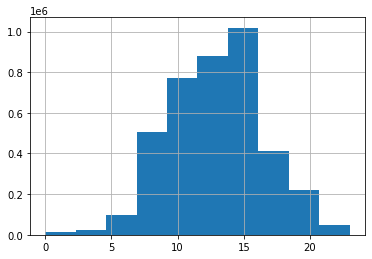

In [178]:
hours_distributions = data['start_time_local'].str.slice(0, 2).astype(int)
fig = hours_distributions.hist().get_figure()

**Распределение звонков по UTC:**

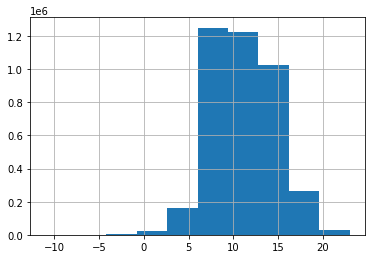

In [179]:
hours_distributions_UTS = hours_distributions - data['time_zone'].astype(int)
fig = hours_distributions_UTS.hist().get_figure()

**Преобразуем время к числу**

In [180]:
# Время указано в секундах
data['start_time_local'] = pd.to_timedelta(data['start_time_local']).dt.total_seconds()
print(data['start_time_local'].head())

0    67383.0
1    42200.0
2    37956.0
3    49502.0
4    49992.0
Name: start_time_local, dtype: float64


**Преобразуем дату к числу**

In [181]:
print(data['time_key'].head())
# Извлечем определенный день в месяце
data['time_key'] = pd.to_datetime(data['time_key'], errors='coerce').dt.day
print(data['time_key'].head())

0    2021-11-01
1    2021-11-01
2    2021-11-01
3    2021-11-01
4    2021-11-01
Name: time_key, dtype: object
0    1
1    1
2    1
3    1
4    1
Name: time_key, dtype: int64



Посмотрим на пропущенные значения и уберем их при необходимости

In [182]:

print(data.isna().mean())
data = data.dropna()

start_time_local    0.0
duration            0.0
num_b_length        0.0
time_key            0.0
id_a                0.0
id_b                0.0
time_zone           0.0
forward             0.0
zero_call_flg       0.0
source_b            0.0
source_f            0.0
dtype: float64


**Посмотрим на распределение фичей**

In [183]:
for col in cat_cols:
    print(f"{col} DISTRIBUTION")
    print(data[col].value_counts())


id_a DISTRIBUTION
6325350     796581
1741727     543328
51817902    280753
52273536    137530
41812796    126601
             ...  
60188729         1
9767824          1
34529479         1
53304427         1
83290750         1
Name: id_a, Length: 16350, dtype: int64
id_b DISTRIBUTION
5137773     64385
67511626     6162
7055569      5063
70502169     4756
3969649      3220
            ...  
21345557        1
24010827        1
41561212        1
48440682        1
25108797        1
Name: id_b, Length: 2405512, dtype: int64
time_zone DISTRIBUTION
 3     2364049
 0     1382857
 4       97344
 2       76354
 7       48637
 5        9136
 1        4690
 8        1615
-1        1386
 10        877
 6         428
 11        184
 9         119
 12         20
Name: time_zone, dtype: int64
forward DISTRIBUTION
0    3620885
1     366811
Name: forward, dtype: int64
zero_call_flg DISTRIBUTION
0    2267314
5    1404606
2     102543
1      94999
3      86638
4      31596
Name: zero_call_flg, dtype: int6

**Визуализируем распределение категориальных фичей**

Распределение часовых зон:


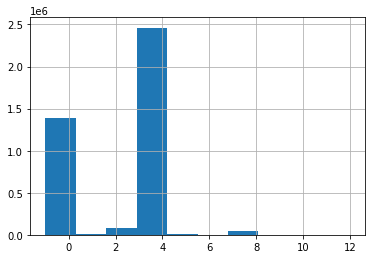

In [184]:

h = data['time_zone'].hist()
fig = h.get_figure()

Распределение категории звонка с нулевой длительностью:

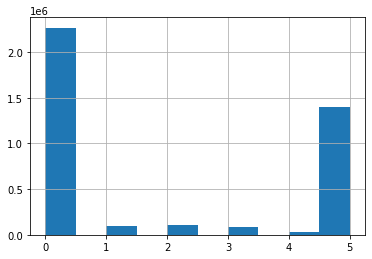

In [185]:
h = data['zero_call_flg'].hist()
fig = h.get_figure()

**Столбцы в таблице целевых переменных**

In [186]:
target_cols = ['id','target','split']
for col in target_cols:
    print(f"{col} DISTRIBUTION")
    print(samples[col].value_counts())

id DISTRIBUTION
196535      1
40982206    1
25798719    1
19050882    1
17647619    1
           ..
23760948    1
78393782    1
75174874    1
23157851    1
12483388    1
Name: id, Length: 46235, dtype: int64
target DISTRIBUTION
0.0    16344
4.0     9966
2.0     6697
3.0     2012
1.0     1923
Name: target, dtype: int64
split DISTRIBUTION
train    36942
test      9293
Name: split, dtype: int64


**Визуализация распределения целевых переменных**

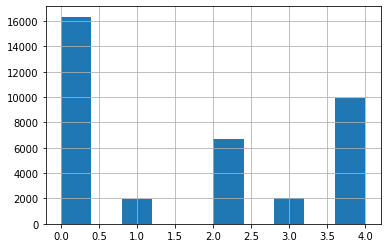

In [187]:
h = samples['target'].hist()
fig = h.get_figure()

**Разделим на тренировочную и тестовую выборки данные о целеввых переменных**

In [188]:
samples_data , samples_predict = [x for _, x in samples.groupby(samples['split'] == 'test')]
samples_data = samples_data.drop('split', axis=1)
samples_predict = samples_predict.drop('split', axis=1)
print(samples_data.head())
print()
print(samples_predict.head())


         id  target
1  63075900     2.0
2  35233935     2.0
3  23557360     4.0
5  42781042     4.0
6  38675005     4.0

          id  target
0     196535     NaN
4   78926486     NaN
7   65130548     NaN
8   27011323     NaN
14  41430879     NaN


**Отсечем данные, о которых нет информации о целевой переменной**

In [189]:

data = data.merge(samples_data[['id','target']], left_on='id_a', right_on='id', how='inner') \
           .drop(columns=['id'])
print(data.shape)
print(data.head())
print(data['target'].value_counts())

(2800317, 12)
   start_time_local  duration  num_b_length  time_key      id_a      id_b  \
0           67383.0         0            10         1  67596082  43588153   
1           59286.0         0            10         1  67596082  82184937   
2           37476.0         0            10         1  67596082  48927355   
3           38474.0         0            10         1  67596082  10241386   
4           49756.0         0            10         1  67596082    229405   

   time_zone  forward  zero_call_flg  source_b  source_f  target  
0          3        0              3         0         1     4.0  
1          3        0              5         0         1     4.0  
2          0        0              5         0         1     4.0  
3          3        0              0         0         1     4.0  
4          0        1              5         1         0     4.0  
4.0    2393949
2.0     139708
3.0     126407
0.0     121095
1.0      19158
Name: target, dtype: int64


In [190]:
print(data.head())

x_train, x_test, y_train, y_test = train_test_split(data[cols], data[['target']], test_size=0.2)
# print(x_train.head())
# print(x_test.head())
# print(y_train.head())
# print(y_test.head())

   start_time_local  duration  num_b_length  time_key      id_a      id_b  \
0           67383.0         0            10         1  67596082  43588153   
1           59286.0         0            10         1  67596082  82184937   
2           37476.0         0            10         1  67596082  48927355   
3           38474.0         0            10         1  67596082  10241386   
4           49756.0         0            10         1  67596082    229405   

   time_zone  forward  zero_call_flg  source_b  source_f  target  
0          3        0              3         0         1     4.0  
1          3        0              5         0         1     4.0  
2          0        0              5         0         1     4.0  
3          3        0              0         0         1     4.0  
4          0        1              5         1         0     4.0  


In [191]:
# Создание объекта дерева решений
clf = DecisionTreeClassifier()
clf = clf.fit(x_train ,y_train)
# Предсказание ответа для тестового набора данных
y_pred = clf.predict(x_test)

   start_time_local  duration  num_b_length  time_key      id_a      id_b  \
0           67383.0         0            10         1  67596082  43588153   
1           59286.0         0            10         1  67596082  82184937   
2           37476.0         0            10         1  67596082  48927355   
3           38474.0         0            10         1  67596082  10241386   
4           49756.0         0            10         1  67596082    229405   

   time_zone  forward  zero_call_flg  source_b  source_f  target  
0          3        0              3         0         1     4.0  
1          3        0              5         0         1     4.0  
2          0        0              5         0         1     4.0  
3          3        0              0         0         1     4.0  
4          0        1              5         1         0     4.0  


**Оценка точности**

In [192]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9896743943549309
